In [ ]:
import pandas as pd
import re

class Attribute:
    def __init__(self, file_name, entity_type=None):
        try:
            self.df = pd.read_table(file_name, encoding="utf-8")
        except Exception:
            self.df = pd.read_table(file_name, encoding="ansi")
        
        self.attr_name = self.df.columns[0]
        self.vals = self.df[self.attr_name].values
        self.ds = re.findall("s[\d][\d]", file_name)[0]
        self.name = ":".join([self.ds, self.attr_name])
        self.relation_type = None
        self.entity_type = entity_type
        if self.entity_type == "E21_Person":
            self.relation_type = ("E12_Production", "P14_carried_out_by") if "E12" in file_name else ("E22_Man-Made_Object", "P62_depicts")
        elif self.entity_type == "E52_Time-Span":
            if "E67" in file_name:
                self.relation_type = ("E67_Birth", "P4_has_time-span")
            elif "E69" in file_name:
                self.relation_type = ("E69_Death", "P4_has_time-span")
            elif "E12" in file_name:
                self.relation_type = ("E12_Production", "P4_has_time-span")
            elif "E8" in file_name:
                self.relation_type = ("E8_Acquisition", "P4_has_time-span")
        elif self.entity_type == "E53_Place":
            if "E12_P7" in file_name:
                self.relation_type = ("E12_Production", "P7_took_place_at")
            elif "E21_P74" in file_name:
                self.relation_type = ("E21_Person", "P74_has_current_or_former_residence")
            elif "E67_P7" in file_name:
                self.relation_type = ("E67_Birth", "P7_took_place_at")
            elif "E22_P55" in file_name:
                self.relation_type = ("E22_Man-made_Object", "P55_has_current_location")
        elif self.entity_type == "E55_Type":
            self.relation_type = ("E12_Production", "P32_used_general_technique") if "type1" in file_name else ("E22_Man-Made_Object", "P2_has_type")
    
    def __repr__(self):
        return self.name


In [25]:
import os
ulan_time_results = [(file, pd.read_csv(r"D:\exp_20211101\ULAN_time_search\\"+ file)) for file in os.listdir(r"D:\exp_20211101\ULAN_time_search")]
ulan_ids = [(file, pd.read_csv(r"D:\exp_20211101\ULAN_id\\"+ file)) for file in os.listdir(r"D:\exp_20211101\ULAN_id")]

In [26]:
import scipy.stats as stats
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy

nlp = spacy.load("en_core_web_md")



def jaccard_similarity(x, y):
    
    if len(x) < 20:
        return 0.0
    
    intersection_cardinality = len(set(x) & set(y))
    union_cardinality = len(set(x) | set(y))
    return intersection_cardinality / float(union_cardinality)


def tfidf_cosine_similarity(x, y):
    
    if len(x) < 20:
        return 0.0
    
    docx = " ".join(set(x))
    docy = " ".join(set(y))
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([docx.lower(), docy.lower()])
    result = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
    return result

def get_freq_dict(data):
    freq_dict = {}.fromkeys(data, 0)
    for ele in data:
        freq_dict[ele] += 1

    return freq_dict


def get_distribution(data):
    freq_dict = get_freq_dict(data)
    histogram_list = []
    i = 0
    for v in reversed(sorted(freq_dict.values())):
        for _ in range(int(v*100/len(data))):
            histogram_list.append(i)
        i += 1
    return histogram_list


def mann_whitney_test(x:np.ndarray, y:np.ndarray):
    
    
    if x.shape == y.shape and (np.equal(x, y)).all():
        return 1.0
    
    if len(x) < 20:
        return 0.0
    
    x = get_distribution(x)
    y = get_distribution(y)
    if len(x) > 1 and len(y) > 1:
        if x[-1] != 0 and y[-1] != 0:
            result = stats.mannwhitneyu(x, y)[1]
            return result

    return 0.0


def attr_rel_similarity(attr_name, rel):
    
    def attr_seg(attr_name):
        s = ""
        if " " not in attr_name:
            for c in attr_name:
                if c.isupper():
                    s += " "
                if c.isalpha():
                    s += c
                else:
                    s += " "
            return s.strip()
        else:
            return attr_name
    
    def rel_seg(r):
        return " ".join(r.split("_")[1:])
    
    attr_name = attr_seg(attr_name)
    
    return nlp(attr_name).similarity(nlp(rel_seg(rel[0]))) + nlp(attr_name).similarity(nlp(rel_seg(rel[1])))


def ulan_birth_score(attr):
    for file, ulan_result in ulan_time_results:
        if attr.ds == file[:3]:
            return list(ulan_result["birth_date"].values == attr.vals).count(True) / len(attr.vals)

        
def ulan_death_score(attr):
    for file, ulan_result in ulan_time_results:
        if attr.ds == file[:3]:
            return list(ulan_result["death_date"].values == attr.vals).count(True) / len(attr.vals)
        

def ulan_person_score(attr):
    if attr.relation_type == ("E22_Man-Made_Object", "P62_depicts"):
        return 1/3
    for file, df in ulan_ids:
        if attr.ds == file[:3]:
            return 1 - (list(df["subject_id"].values).count(0) / len(df))

        
def value_similarity(x, y):
    return mann_whitney_test(x,y), tfidf_cosine_similarity(x,y), jaccard_similarity(x,y)


def attr_similarity(attr_name, candidate_rels):
    return [attr_rel_similarity(attr_name, rel) for rel in candidate_rels]


def ulan_score(attr):
    if attr.entity_type == "E21_Person":
        return ulan_person_score(attr)
    elif attr.entity_type == "E52_Time-Span":
        return ulan_birth_score(attr), ulan_death_score(attr)

In [27]:
import random


def preprocess(attrs, candidate_rels):
    
    features = []
    
    val_flag = False
    ulan_flag = False
    
    if len(candidate_rels) == 2:
        features.extend(["MW1","TF_IDF1", "Jaccard1","MW2","TF_IDF2","Jaccard2"])
        val_flag = True
    
    attr_features = [f"attr_rel{i+1}" for i in range(len(candidate_rels))]
    features.extend(attr_features)
    
    if attrs[0].entity_type == "E21_Person":
        features.append("ulan_person_score")
        ulan_flag = True
    
    if attrs[0].entity_type == "E52_Time-Span":
        features.extend(["ulan_birth_score", "ulan_death_score"])
        ulan_flag = True
    
    features.append("")
    up_cols = ["features" for _ in range(len(features))]
    up_cols[-1] = "label"
    
    feature_df = pd.DataFrame(columns=[up_cols, features])
    
    if val_flag:
        random.seed(1234)
        while True:
            ref_attrs = random.sample(attrs, 2)
            if ref_attrs[0].relation_type == candidate_rels[0] and ref_attrs[1].relation_type == candidate_rels[1]\
                and len(ref_attrs[0].vals) > 20 and len(ref_attrs[1].vals) > 20:
                break
        print(ref_attrs)
            

    
    for attr in attrs:

        attr_ls = []
        
        if val_flag:
#             if attr in ref_attrs:
#                 continue
            val1 = value_similarity(ref_attrs[0].vals, attr.vals)
            val2 = value_similarity(ref_attrs[1].vals, attr.vals)
            attr_ls.extend(list(val1))
            attr_ls.extend(list(val2))
         
        attr_score = attr_similarity(attr.attr_name, candidate_rels)
        attr_ls.extend(list(attr_score))
        
        if ulan_flag:
            uscore = ulan_score(attr)
            if "ulan_person_score" in features:
                attr_ls.append(uscore)
            else:
                attr_ls.extend(list(uscore))
        
        feature_df.loc[attr.name, "features"] = attr_ls
        feature_df.loc[attr.name, "label"] = candidate_rels.index(attr.relation_type)  
    
    return feature_df


In [28]:
os.chdir(r"D:\exp_20211115")
E21_attrs = [Attribute("E21_Person/"+file, "E21_Person") for file in os.listdir("E21_Person")]
E52_attrs = [Attribute("E52_Time-Span/"+file, "E52_Time-Span") for file in os.listdir("E52_Time-Span")]
E55_attrs = [Attribute("E55_Type/"+file, "E55_Type") for file in os.listdir("E55_Type")]
E21_rels = [("E12_Production", "P14_carried_out_by"), ("E22_Man-Made_Object", "P62_depicts")]
E52_rels = [("E67_Birth", "P4_has_time-span"), ("E69_Death", "P4_has_time-span"), ("E12_Production", "P4_has_time-span"), ("E8_Acquisition", "P4_has_time-span")]
E55_rels = [("E12_Production", "P32_used_general_technique"), ("E22_Man-Made_Object", "P2_has_type")]


In [6]:
E21_df = preprocess(E21_attrs, E21_rels)
E52_df = preprocess(E52_attrs, E52_rels)
E55_df = preprocess(E55_attrs, E55_rels)

[s11:artist_name, s23:Title]
[s01:Medium, s21:classifiction]


C:\Users\LRSLXD~1\AppData\Local\Temp/ipykernel_11948/2650530873.py:92: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return nlp(attr_name).similarity(nlp(rel_seg(rel[0]))) + nlp(attr_name).similarity(nlp(rel_seg(rel[1])))


In [8]:
E55_df

features                                          \
                              MW1   TF_IDF1  Jaccard1       MW2   TF_IDF2   
s01:Medium                    1.0       1.0       1.0  0.115853  0.060391   
s02:Object_Facet_Value    0.00227  0.688904  0.095238  0.051815  0.031249   
s02:Object_Work_Type     0.598688   0.37635       0.0  0.030306  0.016007   
s04:materials                 0.0  0.619097  0.117647       0.0  0.020984   
s05:Classification       0.002655       0.0       0.0  0.098175       0.0   
s05:Medium               0.002655       0.0       0.0  0.098175       0.0   
s06:Classification            0.0       0.0       0.0       0.0  0.088589   
s06:Medium               0.558201  0.614655  0.066667  0.417653       0.0   
s07:technique                 0.0  0.520352     0.025       0.0  0.068548   
s12:technique                 0.0  0.343741  0.004884       0.0   0.15104   
s13:TypeOfArtwork        0.001724   0.35886  0.056604  0.022007  0.118893   
s14:technique                 0.0  0.667852  0.009009       0.0  0.094589   
s15:classification            0.0       0.0       0.0       0.0  0.088589   
s15:medium               0.022285  0.701756  0.142857  0.000086       0.0   
s17:technique                 0.0  0.734422  0.016949       0.0  0.101922   
s19:materials                 0.0  0.619097       0.0       0.0  0.020984   
s21:classifiction        0.115853  0.060391       0.0       1.0       1.0   
s21:medium               0.623488  0.750806  0.009554  0.446282  0.096895   
s23:Classification            0.0       0.0       0.0       0.0  0.088589   
s23:Medium               0.558201  0.614655  0.066667  0.417653       0.0   
s25:Subtype_of_Art_type  0.021282  0.582406  0.055556  0.302321       0.0   
s25:Type_of_Art_type          0.0       0.0       0.0       0.0  0.088589   
s26:type                 0.986844  0.022692       0.0  0.122619  0.018582   
s28:Category             0.000001       0.0       0.0  0.000072       0.0   
s28:materials            0.000001  0.560939  0.090909  0.000072       0.0   
s29:Medium                    0.0  0.530031       0.0       0.0       0.0   
s29:Object_Name_type     0.002655  0.049559       0.0  0.098175       0.0   

                                                      label  
                         Jaccard2 attr_rel1 attr_rel2        
s01:Medium                    0.0  0.727143  0.679812     0  
s02:Object_Facet_Value        0.0  0.858517  1.222888     0  
s02:Object_Work_Type     0.066667  1.005741  1.496711     1  
s04:materials                 0.0  0.909513  0.675539     0  
s05:Classification            0.0  0.575876  0.496671     1  
s05:Medium                    0.0  0.727143  0.679812     0  
s06:Classification       0.083333  0.575876  0.496671     1  
s06:Medium                    0.0  0.727143  0.679812     0  
s07:technique                 0.0  1.081696  0.701826     0  
s12:technique                 0.0  1.081696  0.701826     0  
s13:TypeOfArtwork             0.0  0.946257  1.258571     0  
s14:technique                 0.0  1.081696  0.701826     0  
s15:classification       0.083333  0.575876  0.496671     1  
s15:medium                    0.0  0.727143  0.679812     0  
s17:technique                 0.0  1.081696  0.701826     0  
s19:materials                 0.0  0.909513  0.675539     0  
s21:classifiction             1.0       0.0       0.0     1  
s21:medium                    0.0  0.727143  0.679812     0  
s23:Classification       0.083333  0.575876  0.496671     1  
s23:Medium                    0.0  0.727143  0.679812     0  
s25:Subtype_of_Art_type       0.0  1.005448  1.227999     0  
s25:Type_of_Art_type     0.083333   1.04264  1.406881     1  
s26:type                 0.052632    0.7798   1.30097     1  
s28:Category                  0.0  0.478217  0.691253     1  
s28:materials                 0.0  0.909513  0.675539     0  
s29:Medium                    0.0  0.727143  0.679812     0  
s29:Object_Name_type          0.0  0.774804  1.447254  

In [31]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus
from IPython.display import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns


def split_data(df, seed):
    train = df.groupby("label").apply(lambda x:x.sample(len(x)//2, random_state = seed))
    _,train.index = zip(*train.index)
    test = df[~df.isin(train)].dropna()
    return train, test


def feature_selection_by_RFE(train_df):
    
    features = train_df["features"]
    labels = train_df["label"].apply(int)
    
    decision_tree = DecisionTreeClassifier(random_state=1, class_weight="balanced")
    
    rfecv = RFECV(estimator=decision_tree, step=1, scoring="accuracy")
    rfecv.fit(features, labels)
    
    return features.columns[rfecv.support_]


def train_tree_model(train_df, selected_features):
    features = train_df["features"][selected_features]
    labels = train_df["label"].apply(int)
    
    decision_tree = DecisionTreeClassifier(random_state=1, class_weight="balanced")
    
    decision_tree.fit(features, labels)
    return decision_tree


def result(tree_model, test_df, selected_features, rels):

    pred = tree_model.predict(test_df["features"][selected_features])
    result_df = pd.DataFrame(test_df.label)
    result_df["predict"] = pred
    class_names = [rel[0] for rel in rels]
    dot_data = tree.export_graphviz(tree_model, out_file=None, feature_names=selected_features, class_names=class_names)
    graph = pydotplus.graph_from_dot_data(dot_data)
    matrix = confusion_matrix(result_df.label.apply(int), result_df.predict.apply(int))
    matrix_df = pd.DataFrame(matrix, index=class_names, columns=class_names)
    return result_df.applymap(lambda x: rels[x][0]), graph, matrix_df

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least popul

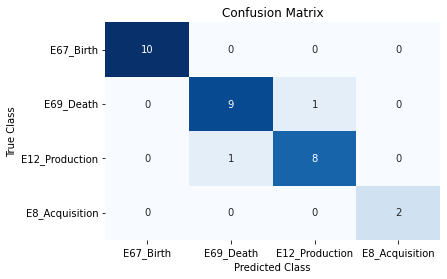

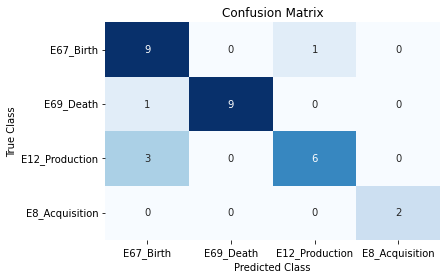

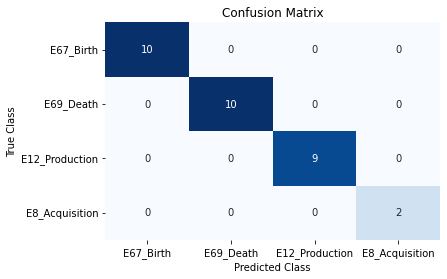

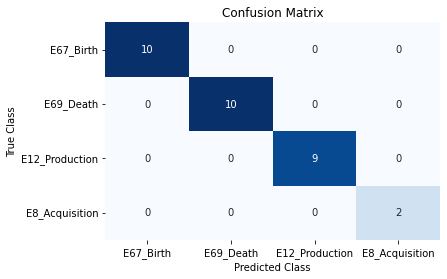

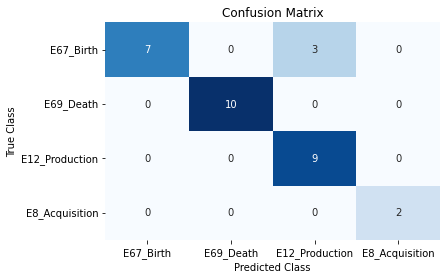

In [528]:
f = open("result/E52_Time-Span/selected_features.txt", 'w')
for i in range(1,6):
    E52_train, E52_test = split_data(E52_df, i)
    selected_features = feature_selection_by_RFE(E52_train)
    f.write(f"exp_{i}: ")
    f.write("\t".join(list(selected_features)))
    f.write("\n")
    tree_model = train_tree_model(E52_train, selected_features)
    result_df, graph, matrix_df = result(tree_model, E52_test, selected_features, E52_rels)
    result_df.to_csv(f"result/E52_Time-Span/exp_{i}.csv")
    graph.write_pdf(f"result/E52_Time-Span/tree_{i}.pdf")
    plt.figure()
    sns.heatmap(matrix_df, annot=True, cbar=None, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.savefig(f"result/E52_Time-Span/matrix_{i}.pdf")
    
f.close()

c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least popul

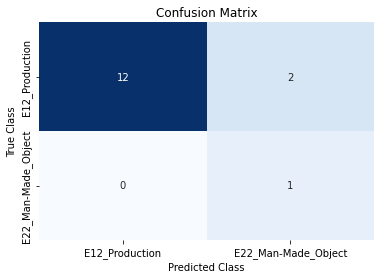

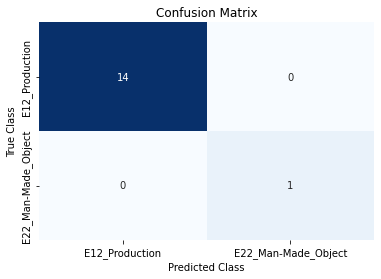

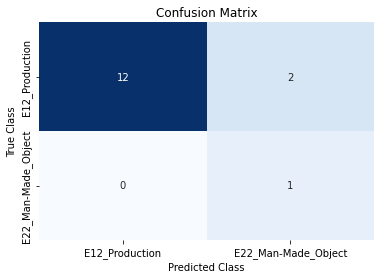

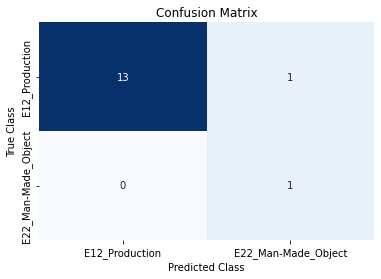

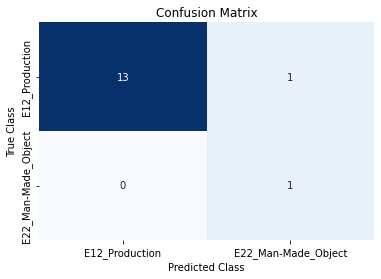

In [529]:
f = open("result/E21_Person/selected_features.txt", 'w')
for i in range(1,6):
    E21_train, E21_test = split_data(E21_df,i)
    selected_features = feature_selection_by_RFE(E21_train)
    f.write(f"exp_{i}: ")
    f.write("\t".join(list(selected_features)))
    f.write("\n")
    tree_model = train_tree_model(E21_train, selected_features)
    result_df, graph, matrix_df = result(tree_model, E21_test, selected_features, E21_rels)
    result_df.to_csv(f"result/E21_Person/exp_{i}.csv")
    graph.write_pdf(f"result/E21_Person/tree_{i}.pdf")
    plt.figure()
    sns.heatmap(matrix_df, annot=True, cbar=None, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.savefig(f"result/E21_Person/matrix_{i}.pdf")
f.close()

c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  

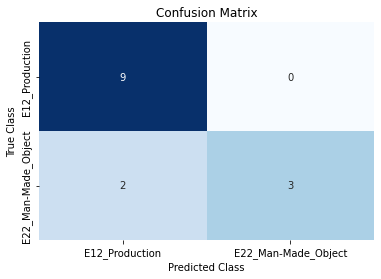

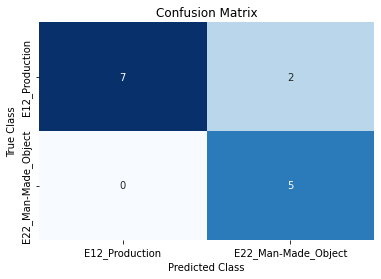

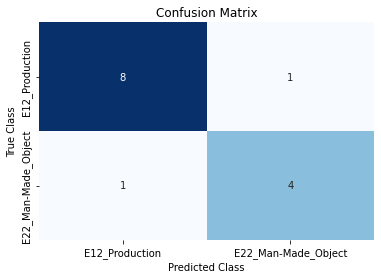

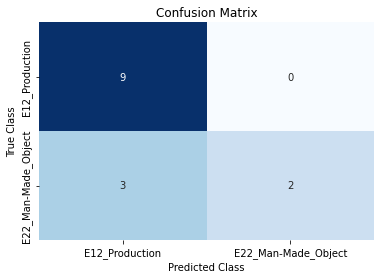

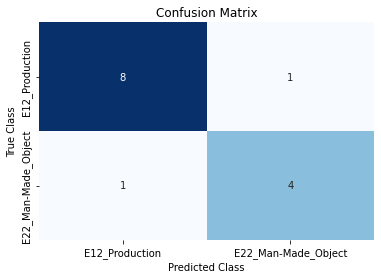

In [530]:
f = open("result/E55_Type/selected_features.txt", 'w')
for i in range(1,6):
    E55_train, E55_test = split_data(E55_df, i)
    selected_features = feature_selection_by_RFE(E55_train)
    f.write(f"exp_{i}: ")
    f.write("\t".join(list(selected_features)))
    f.write("\n")
    tree_model = train_tree_model(E55_train, selected_features)
    result_df, graph, matrix_df = result(tree_model, E55_test, selected_features, E55_rels)
    result_df.to_csv(f"result/E55_Type/exp_{i}.csv")
    graph.write_pdf(f"result/E55_Type/tree_{i}.pdf")
    plt.figure()
    sns.heatmap(matrix_df, annot=True, cbar=None, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.savefig(f"result/E55_Type/matrix_{i}.pdf")
f.close()

In [527]:
E52_train, E52_test = split_data(E52_df, 1)
selected_features = feature_selection_by_RFE(E52_train)


c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\users\lr slxdr\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


['attr_rel1', 'attr_rel2', 'attr_rel4', 'ulan_birth_score', 'ulan_death_score']